Cross-validation : https://velog.io/@jee-9/Scikit-learn-교차-검증Cross-validation-KFold-Stratified-KFold-crossvalscore

Object Detection 은 classification과 다르게 하나의 이미지에 여러개의 class가 존재하기 때문에 Cross-validation(CV)를 나누는 방법이 다릅니다. 따라서 어떻게 CV를 나누면 좋을지 알아보도록 하겠습니다.

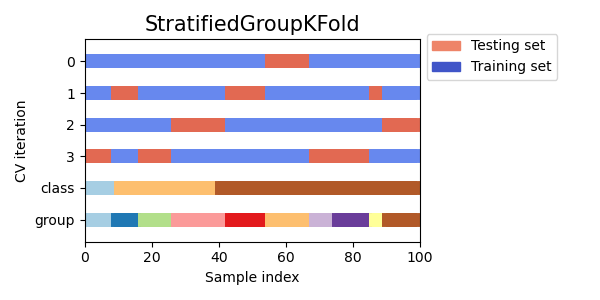

Object Detection에서는 stratifiedGroupKfold를 주로 활용합니다.

stratifiedGroupKfold는 class를 group 별로 묶어서 class별 분포를 유사하게 나누는 방법입니다. 여기서 group은 Object Detection에서 하나의 image안에 여러개의 class가 존재할 수 있으므로 image별로 group을 나눠주면 됩니다. 그렇게 되면 이미지별로 group을 묶었기 때문에 stratifiedKFold를 사용할 수 있게 됩니다.

출처 : https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

필요한 파라미터

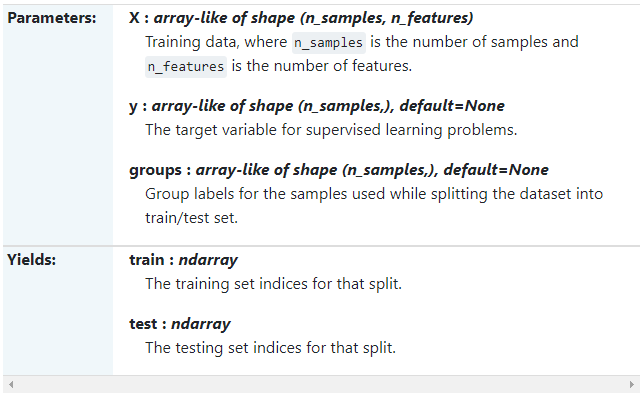


In [2]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

# load json annotation = {dataset file 경로}
annotation = '../../dataset/train.json'

with open(annotation) as f: data = json.load(f)

var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]
X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411)

for train_idx, val_idx in cv.split(X, y, groups):
    print("TRAIN:", groups[train_idx])
    print(" ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print(" ", y[val_idx])


TRAIN: [   0    1    1 ... 4881 4881 4881]
  [0 3 7 ... 7 1 7]
 TEST: [   6   13   13 ... 4882 4882 4882]
  [1 6 7 ... 0 1 1]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   5    5    5 ... 4876 4876 4878]
  [7 0 0 ... 0 2 0]
TRAIN: [   0    3    3 ... 4882 4882 4882]
  [0 2 6 ... 0 1 1]
 TEST: [   1    1    1 ... 4877 4877 4880]
  [3 7 4 ... 7 7 0]
TRAIN: [   1    1    1 ... 4882 4882 4882]
  [3 7 4 ... 0 1 1]
 TEST: [   0    3    3 ... 4881 4881 4881]
  [0 2 6 ... 7 1 7]
TRAIN: [   0    1    1 ... 4882 4882 4882]
  [0 3 7 ... 0 1 1]
 TEST: [   4    4    4 ... 4868 4872 4872]
  [1 1 1 ... 2 4 6]


그리고 실제로 데이터가 잘 나누어졌는지는 아래의 코드를 통해 확인 했습니다! (아래 코드는 캐글 노트북 - https://www.kaggle.com/code/jakubwasikowski/stratified-group-k-fold-cross-validation/notebook 을 참고하였습니다~)

In [7]:
# check distribution
from collections import Counter
import pandas as pd

def get_distribution(y):
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values())

    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in range(np.max(y) +1)]

distrs = [get_distribution(y)]
index = ['training set']

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)):
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx] #

    assert len(set(train_gr) & set(val_gr)) == 0 
    
    distrs.append(get_distribution(train_y))
    distrs.append(get_distribution(val_y))
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')

categories = [d['name'] for d in data['categories']]
pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,17.14%,27.45%,3.88%,4.04%,4.24%,12.72%,5.46%,22.37%,0.69%,2.02%
train - fold0,16.96%,27.45%,3.79%,4.13%,4.48%,12.61%,5.51%,22.28%,0.77%,2.02%
val - fold0,17.85%,27.42%,4.23%,3.70%,3.26%,13.15%,5.25%,22.77%,0.35%,2.02%
train - fold1,17.14%,27.24%,4.01%,3.98%,4.28%,12.77%,5.38%,22.32%,0.67%,2.20%
val - fold1,17.12%,28.17%,3.41%,4.26%,4.12%,12.51%,5.72%,22.57%,0.73%,1.38%
train - fold2,17.31%,27.39%,3.83%,4.08%,4.13%,12.80%,5.14%,22.68%,0.69%,1.94%
val - fold2,16.42%,27.68%,4.05%,3.88%,4.70%,12.36%,6.76%,21.12%,0.69%,2.35%
train - fold3,17.30%,27.47%,3.87%,4.06%,4.22%,12.63%,5.49%,22.39%,0.63%,1.95%
val - fold3,16.50%,27.36%,3.88%,3.99%,4.33%,13.07%,5.33%,22.30%,0.92%,2.32%
train - fold4,16.97%,27.67%,3.88%,3.97%,4.10%,12.77%,5.76%,22.20%,0.68%,2.00%


데이터셋을 나눈 뒤, 데이터셋이 잘 나누어졌는지 확인하는 과정도 필요합니다. 위의 코드를 사용해서 데이터셋이 잘 나누어졌는지 확인해보세요.

위의 방식 이외에도 어떤 식으로 데이터셋을 Split하면 좋을지, 우리 팀은 어떤 전략을 사용했는지 공유해주세요. : )